<a href="https://colab.research.google.com/github/daniel-hain/review_twin_transition/blob/main/python/BERTopic_bibliomap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERTopic EIST

* First tryout on EIST topic modelling using BERT an reprentation learning.


## Setup

In [8]:
# Weird monkey patch
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# When using openai (doesnt work right now)
!pip install --upgrade openai  -q gwpy

In [9]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')
# Change directory

In [10]:
# Installing BERTopic
!pip install bertopic  -q gwpy

## Data

* Title + Abstracts of all articles

In [11]:
import os
import pandas as pd
docs = pd.read_csv("https://github.com/daniel-hain/review_twin_transition/raw/main/data/data_text_all.csv")
docs.head()

UT    PY  \
0  2-S2.0-85074862753  2020   
1  2-S2.0-85074688306  2020   
2  2-S2.0-84961855482  2016   
3  2-S2.0-85041773666  2018   
4  2-S2.0-85075890378  2020   

                                                text  com    dgr_int  
0  assessing relations between circular economy a...  4.0   1.822842  
1  assessing the potentials of digitalization as ...  NaN        NaN  
2  creative destruction or mere niche support? in...  1.0  14.671114  
3  disruption and low-carbon system transformatio...  1.0   9.601300  
4  forever stuck in old ways? pluralising incumbe...  1.0   5.162037

# **Topic Modeling**



## Training



In [12]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.representation import KeyBERTInspired
from bertopic.representation import TextGeneration

from sentence_transformers import SentenceTransformer
from transformers.pipelines import pipeline

from hdbscan import HDBSCAN
from umap import UMAP

from sklearn.feature_extraction.text import CountVectorizer

In [13]:
# Own stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

new_stopwords = ["study", "studies", "paper", "insight", "insights", "research", "literature", "framework", "frameworks","rights","reserved" , "study", "studies", "these", "this", "paper", "result", "model", "approach", "article", "author", "method", "understand", "focus", "examine", "aim", "argue", "identify",
          "increase", "datum", "potential", "explore", "include", "issue", "propose", "address", "apply", "require", "analyse", "relate", "finding",
          "analyze", "discuss", "contribute", "publish", "involve", "draw", "lead", "exist", "set", "reduce", "create", "form", "explain", "play",
          "affect", "regard", "associate", "establish", "follow", "conclude", "define", "strong", "attempt", "finally", "elsevier", "offer",
          "taylor", "francis", "copyright", "springer", "wiley", "emerald", "copyright", "b.v"]
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(new_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
# Some hyperparameters
umap_n_neighbors = 5
umap_n_components = 10
umap_min_dist = 0

hdbscan_min_cluster_size = 10
hdbscan_min_samples = hdbscan_min_cluster_size

# EMBEDDING MODEL:
embedding_model = "allenai-specter"

# DIMENSIONALITY REDUCTION
umap_model = UMAP(n_neighbors=umap_n_neighbors,
                  n_components=umap_n_components,
                  min_dist=umap_min_dist,
                  metric='cosine',
                  random_state=1337)

# CLUSTERING: resuce min_cluster_size and min_samples
hdbscan_model = HDBSCAN(min_cluster_size=hdbscan_min_cluster_size,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True,
                        min_samples=hdbscan_min_samples)

# VECTORIZER: custom vectorizer to get rid of stopwords
vectorizer_model = CountVectorizer(stop_words=stpwrd,
                                   min_df = 5)

# TFIDF Weighting: Weighting model with redued stoppwords
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,
                                     reduce_frequent_words=True)

In [15]:
import openai
from bertopic.representation import OpenAI

from getpass import getpass # get from: https://docs.google.com/spreadsheets/d/1Zjy7IFRqowBsB1W7vPRQRYcqANOo82LJEvNR22iAsA8/edit#gid=0
#openai.api_key = getpass('Enter OpenAi secret value: ')

In [16]:
## REPRESENTATION MODEL:
representation_model = MaximalMarginalRelevance(diversity=0.7)
#representation_model = KeyBERTInspired()
#representation_model = OpenAI()

In [17]:
# BEWRTopic: specify all custom models and n_grams
topic_model = BERTopic(nr_topics="auto",
                       language="english",
                       calculate_probabilities=True,
                       verbose=True,
                       n_gram_range=(1, 3),
                       # seed_topic_list=seed_topic_list, #
                       embedding_model=embedding_model,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       vectorizer_model=vectorizer_model,
                       ctfidf_model=ctfidf_model,
                       representation_model=representation_model)

In [18]:
topics, probs = topic_model.fit_transform(docs.loc[:,'text'])

Batches:   0%|          | 0/86 [00:00<?, ?it/s]

2023-09-05 15:42:54,836 - BERTopic - Transformed documents to Embeddings
2023-09-05 15:43:15,687 - BERTopic - Reduced dimensionality
2023-09-05 15:43:16,054 - BERTopic - Clustered reduced embeddings
2023-09-05 15:43:20,036 - BERTopic - Reduced number of topics from 33 to 20


## Extracting Topics
* After fitting our model, we can start by looking at the results.
* Typically, we look at the most frequent topics first as they best represent the collection of documents.
* -1 refers to all outliers and should typically be ignored.

In [19]:
freq = topic_model.get_topic_info(); freq.head(50)

Topic  Count                                            Name  \
0      -1    270              -1_pollution_water_ict_regulations   
1       0    675         0_knowledge_firms_countries_convergence   
2       1    599       1_manufacturing_industry_economy_business   
3       2    372         2_environmental_innovation_china_porter   
4       3    351        3_transition_actors_sustainability_power   
5       4    104             4_resilience_climate_cities_justice   
6       5     49              5_warming_river_rainfall_projected   
7       6     40    6_agriculture_waste_conflicts_sustainability   
8       7     35           7_cities_mobility_tourism_initiatives   
9       8     34                   8_ai_robotics_care_employment   
10      9     30             9_production_co2_sustainable_plants   
11     10     28           10_emissions_nations_co2_ecologically   
12     11     26  11_chain_contracts_transparency_organisational   
13     12     25                12_building_lca_behaviors_design   
14     13     25     13_additive_recycling_thermal_manufacturing   
15     14     23          14_forecasting_load_neural_electricity   
16     15     21    15_electric_vehicle_mobility_reconfiguration   
17     16     15               16_fuel_vehicle_protection_levers   
18     17     15                           17_heat_95_air_burden   
19     18     14            18_electricity_load_forecast_periods   

                                       Representation  \
0   [pollution, water, ict, regulations, china, fi...   
1   [knowledge, firms, countries, convergence, pat...   
2   [manufacturing, industry, economy, business, b...   
3   [environmental, innovation, china, porter, ren...   
4   [transition, actors, sustainability, power, re...   
5   [resilience, climate, cities, justice, househo...   
6   [warming, river, rainfall, projected, variabil...   
7   [agriculture, waste, conflicts, sustainability...   
8   [cities, mobility, tourism, initiatives, acces...   
9   [ai, robotics, care, employment, ethical, repl...   
10  [production, co2, sustainable, plants, waste, ...   
11  [emissions, nations, co2, ecologically, oecd, ...   
12  [chain, contracts, transparency, organisationa...   
13  [building, lca, behaviors, design, assessment,...   
14  [additive, recycling, thermal, manufacturing, ...   
15  [forecasting, load, neural, electricity, consu...   
16  [electric, vehicle, mobility, reconfiguration,...   
17  [fuel, vehicle, protection, levers, subsidy, t...   
18  [heat, 95, air, burden, health, weather, pollu...   
19  [electricity, load, forecast, periods, transfe...   

                                  Representative_Docs  
0   [the influence of energy prices on adoption of...  
1   [industry funding of university research and s...  
2   [diving into emerging economies bottleneck: in...  
3   [the drivers of eco-innovation and its impact ...  
4   [exploring the role of phase-out policies for ...  
5   [using climate finance to advance climate just...  
6   [extreme climatic events drive mammal irruptio...  
7   [transition heuristic frameworks in research o...  
8   [mediating sustainability and liveability-turn...  
9   [economics of artificial intelligence: implica...  
10  [circular bioeconomy business models to overco...  
11  [economic development and the carbon intensity...  
12  [blockchain technology and the circular econom...  
13  [calculation and evaluation of circularity ind...  
14  [investigation of closed-loop manufacturing wi...  
15  [annual electric load forecasting by a least s...  
16  [car and the city: socio-technical transition ...  
17  [genetic algorithm optimized neural network ba...  
18  [heat-related mortality in india: excess all-c...  
19  [forecasting electricity smart meter data usin...

## Attributes

* There are a number of attributes that you can access after having trained your BERTopic model:


| Attribute | Description |
|------------------------|---------------------------------------------------------------------------------------------|
| topics_               | The topics that are generated for each document after training or updating the topic model. |
| probabilities_ | The probabilities that are generated for each document if HDBSCAN is used. |
| topic_sizes_           | The size of each topic                                                                      |
| topic_mapper_          | A class for tracking topics and their mappings anytime they are merged/reduced.             |
| topic_representations_ | The top *n* terms per topic and their respective c-TF-IDF values.                             |
| c_tf_idf_              | The topic-term matrix as calculated through c-TF-IDF.                                       |
| topic_labels_          | The default labels for each topic.                                                          |
| custom_labels_         | Custom labels for each topic as generated through `.set_topic_labels`.                                                               |
| topic_embeddings_      | The embeddings for each topic if `embedding_model` was used.                                                              |
| representative_docs_   | The representative documents for each topic if HDBSCAN is used.                                                |

For example, to access the predicted topics for the first 10 documents, we simply run the following:

# **Visualization**
* There are several visualization options available in BERTopic, namely the visualization of topics, probabilities and topics over time.
* Topic modeling is, to a certain extent, quite subjective. * Visualizations help understand the topics that were created.

## General topic relation

In [20]:
topic_model.visualize_topics()

## Visualize Terms

We can visualize the selected terms for a few topics by creating bar charts out of the c-TF-IDF scores for each topic representation. Insights can be gained from the relative c-TF-IDF scores between and within topics. Moreover, you can easily compare topic representations to each other.

In [21]:
topic_model.visualize_barchart(top_n_topics=50, n_words = 10)

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

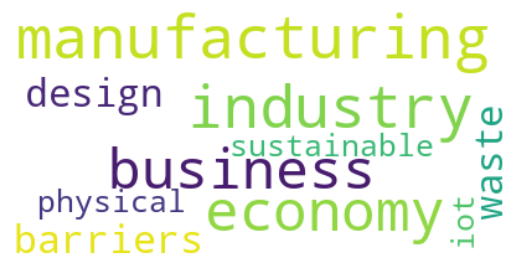

In [23]:
# Show wordcloud
create_wordcloud(topic_model, topic=1)

In [24]:
# Representative docs
rep_doc = topic_model.get_representative_docs()
rep_doc = pd.DataFrame(rep_doc)
rep_doc.T

0  \
-1   the influence of energy prices on adoption of ...   
 0   industry funding of university research and sc...   
 1   diving into emerging economies bottleneck: ind...   
 2   the drivers of eco-innovation and its impact o...   
 3   exploring the role of phase-out policies for l...   
 4   using climate finance to advance climate justi...   
 5   extreme climatic events drive mammal irruption...   
 6   transition heuristic frameworks in research on...   
 7   mediating sustainability and liveability-turni...   
 8   economics of artificial intelligence: implicat...   
 9   circular bioeconomy business models to overcom...   
 10  economic development and the carbon intensity ...   
 11  blockchain technology and the circular economy...   
 12  calculation and evaluation of circularity indi...   
 13  investigation of closed-loop manufacturing wit...   
 14  annual electric load forecasting by a least sq...   
 15  car and the city: socio-technical transition p...   
 16  genetic algorithm optimized neural network bas...   
 17  heat-related mortality in india: excess all-ca...   
 18  forecasting electricity smart meter data using...   

                                                     1  \
-1   financial barriers and environmental innovatio...   
 0   creating conditions for innovative performance...   
 1   supply chain 4.0: concepts, maturity and resea...   
 2   how do environmental regulation and foreign in...   
 3   mapping the winds of whole system reconfigurat...   
 4   managing the health effects of temperature in ...   
 5   past (1950–2017) and future (−2100) temperatur...   
 6   interactions between niche and regime: an anal...   
 7   assessing the potentials of digitalization as ...   
 8   psychological reactions to human versus roboti...   
 9   water availability and water usage solutions f...   
 10  the relationship between national-level carbon...   
 11  copyright in the blockchain era: promises and ...   
 12  a review of the circularity gap in the constru...   
 13  mechanical properties of direct waste printing...   
 14  a seasonal direct optimal hybrid model of comp...   
 15  low-carbon transition via system reconfigurati...   
 16  prospects of fuel cell auxiliary power units i...   
 17  health impacts of air pollution exposure from ...   
 18  electricity demand forecasting for decentralis...   

                                                     2  
-1   how industry 4.0 technologies and open innovat...  
 0   the new world of discovery, invention, and inn...  
 1   the role and impact of industry 4.0 and the in...  
 2   does increasing carbon emissions lead to accel...  
 3   the socio-technical dynamics of low-carbon tra...  
 4   inclusive approaches to urban climate adaptati...  
 5   projected seasonal changes in large-scale glob...  
 6   challenges of food waste governance: an assess...  
 7   effects of the covid-19 pandemic on the use an...  
 8   artificial intelligence in service. artificial...  
 9   towards a bio-based circular economy in organi...  
 10  the changing effect of economic development on...  
 11  tunneling the barriers of blockchain technolog...  
 12  disassembly and deconstruction analytics syste...  
 13  the development of a strategy for direct part ...  
 14  a hybrid annual power load forecasting model b...  
 15  a socio-technical transition path for new ener...  
 16  the role of public and private protection in d...  
 17  fertility, mortality, migration, and populatio...  
 18  responsiveness of residential electricity dema...

In [25]:
embeddings = topic_model.embedding_model.embed_documents(docs.loc[:,'text'])
pd.DataFrame(embeddings).to_csv('embeddings_specter.csv')

In [26]:
topic_model.visualize_documents(docs.loc[:,'text'], embeddings=embeddings)

## Visualize Topic Hierarchy

* The topics that were created can be hierarchically reduced.
* In order to understand the potential hierarchical structure of the topics, we can create clusters and visualize how they relate to one another.
* This might also help selecting an appropriate nr_topics when reducing the number of topics that you have created.

In [27]:
# Calculate Hirarchy
hierarchical_topics = topic_model.hierarchical_topics(docs.loc[:,'text'])

100%|██████████| 18/18 [00:01<00:00, 14.19it/s]


In [28]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [29]:
# Run the visualization with the original embeddings
topic_model.visualize_hierarchical_documents(docs.loc[:,'text'], hierarchical_topics, embeddings=embeddings, level_scale = 'log')

## Topics over time

In [30]:
# Calculate topics over time
topics_over_time = topic_model.topics_over_time(docs.loc[:,'text'],
                                                docs.loc[:,'PY'])

38it [00:16,  2.31it/s]


In [31]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=50)

## Visualize Topic Similarity
Having generated topic embeddings, through both c-TF-IDF and embeddings, we can create a similarity matrix by simply applying cosine similarities through those topic embeddings. The result will be a matrix indicating how similar certain topics are to each other.

In [32]:
topic_model.visualize_heatmap(n_clusters=5, width=1000, height=1000)

# Optimal: Finetune topics

Only do if you think something should be changes

In [33]:
# VECTORIZER: custom vectorizer to get rid of stopwords
#vectorizer_model = CountVectorizer(stop_words=stpwrd, min_df = 10)

# TFIDF Weighting: Weighting model with redued stoppwords
#ctfidf_model = ClassTfidfTransformer(bm25_weighting=True,reduce_frequent_words=True)

## REPRESENTATION MODEL:
# rep_mm = MaximalMarginalRelevance(diversity=0.8)
# rep_kb = KeyBERTInspired()
# rep_oai = OpenAI()
# representation_model = rep_mm # [rep_mm, rep_kb]

# topic_model.update_topics(docs.loc[:,'text'], n_gram_range=(1, 3),
#                          vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model, representation_model=representation_model)

In [34]:
# Reduce topics if wanted
# topic_model.reduce_topics(docs, nr_topics=30)

## Visualize Topic Probabilities

- The variable `probabilities` that is returned from `transform()` or `fit_transform()` can  be used to understand how confident BERTopic is that certain topics can be found in a document.



In [35]:
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(docs.loc[:,'text'], calculate_tokens=True)

100%|██████████| 3/3 [00:09<00:00,  3.10s/it]


In [40]:
# Select a document
doc_nr = 102
docs.loc[doc_nr]

UT                                        2-S2.0-85027531497
PY                                                      2017
text       power in sustainability transitions: analysing...
com                                                      1.0
dgr_int                                             6.991248
Name: 102, dtype: object

In [37]:
# Get the probability distribution
topic_model.visualize_distribution(probs[doc_nr], min_probability=0.01)

In [38]:
# Visualize the token-level distributions
doc_topic_dist = topic_model.visualize_approximate_distribution(docs.loc[doc_nr,'text'], topic_token_distr[doc_nr])
doc_topic_dist

# Work in progress: Manual ChatGTP topic summary:

In [39]:
top_n = 5
n_doc = hdbscan_min_cluster_size

promt_intro = "I want you to act as a professor in social science. I want you to identify the reearch topic of following documents, which are titles plus abstacts of scientific journal article publications. They are representative articles for the topic to be identified. The journal is called  'Environmental Innovation and Societal Transitions'. The journal offers a platform for reporting studies of innovations and socio-economic transitions to enhance an environmentally sustainable economy and thus solve structural resource scarcity and environmental problems, notably related to fossil energy use and climate change. This involves attention for technological, organizational, economic, institutional and political innovations as well as economy-wide and sector changes, such as in the areas of energy, transport, agriculture and water management. The journal aims to tackle the most difficult questions, dealing with social, economic, behavioral-psychological and political barriers and opportunities as well as their complex interaction. The journal is multidisciplinary in spirit and methodologically open, and invites contributions from a broad range of disciplines within the social, environmental and innovation sciences. Specific research areas covered include: Theoretical analysis, formal modeling, empirical studies, policy discussion and a critical survey of relevant literature. Practical cases may address transitions in specific sectors, cities or regions. Articles on historical transitions not specifically related to environment and sustainability are welcome if they include a section with unique lessons for sustainability transitions. A non-exhaustive list of keywords and themes is as follows: behavior in line with bounded rationality, development theories, diffusion of innovations, environmental regulation, formal modeling, geography of innovations, historical transitions, increasing returns to scale and path dependence, innovation policy, institutional barriers, international cooperation and coordination, learning-by-doing, learning curves, lock-in, new governance, niche markets, optimal technological diversity, regime analysis, social and political power, strategic niche management, rebound effect, recombinant innovation, sector structure, social learning, transition experiments, technological regimes, transition pathways/mechanisms, vested interests, visions of the future."

promt_doc_intro = "Now I provide you the 10 articles. Every article starts with an '-', and ends with a linebreak:"
promt_doc = topic_model.get_document_info(docs.loc[:,'text']).sort_values(['Representative_document', 'Probability'],ascending=False).groupby('Topic').head(n_doc)
promt_doc['Document'] = '- ' + promt_doc['Document']
promt_doc = promt_doc.groupby('Topic', as_index=False).agg({'Document' : ' \n '.join}).query("Topic == @top_n").reset_index().loc[0,'Document']
promt_key_intro = "Now that your recieved the corresponding documents, I will also provide you some keywords describing the topic. They are sepperated with an ','"

promt_key = pd.DataFrame(topic_model.get_topic(top_n))
promt_key = [', '.join(promt_key.loc[:,0])]

promt_final = "Your task is to summarize the topic by a short label of 2-7 words, plus a short description of 3-5 sentences. It should consider the article content and the provided keywords, both against the background of the journal they are published in. It should be brief, focussed, clear, and avoid redundancies. This summary should highlight the commonality of the documents. It should indicate the main theoretical theme, research framework applied, context, potential contributions and implications. It should also indicate if the research in this topic is more quantitative or qualitative, on a macro or micro level, and aimed at theoretical, policy, or industry implications."

print(promt_intro, promt_doc_intro, promt_doc, promt_key_intro, promt_key, promt_final, sep = " \n \n ")

ValueError: ignored

# Export all topics

In [50]:
# all topic / documents
df = pd.DataFrame({'topic': topics, 'document': docs.UT})

In [53]:
pd.DataFrame(df).to_csv('documents_topic.csv')

In [56]:
df_topic = topic_model.get_topic_info()

In [58]:
pd.DataFrame(df_topic).to_csv('topic_rep.csv')